# Lab9 - Spatial Data Analysis Created in class by SRK325 and completed by dlk253 to satisfy HW10 for PUI2016
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [78]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [79]:

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt

## Working with Shape File

### Loading Census Tract Shape File¶

In [81]:
from geopandas import GeoDataFrame
shape_path="CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010 #make sure the index is set to the boro census tract

### Coordinate systems, projections, and transformations 

In [85]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#NAD planer coordinates of 1983
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
#print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

### Visualize the Cencus Tract boundaries colored by boroughs

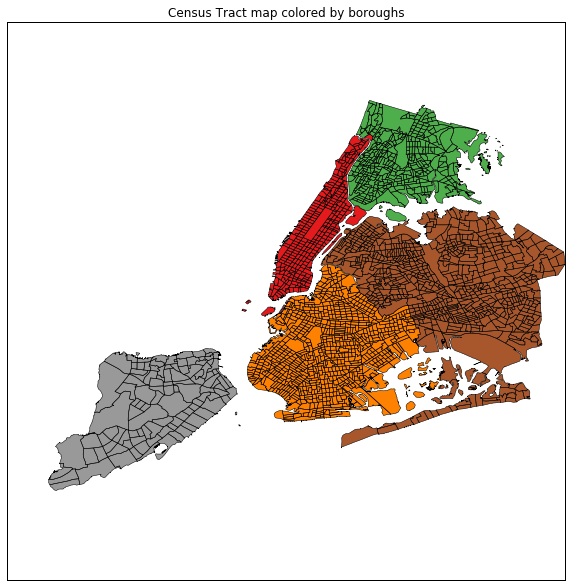

In [86]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [87]:
# put this in PUI
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [88]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

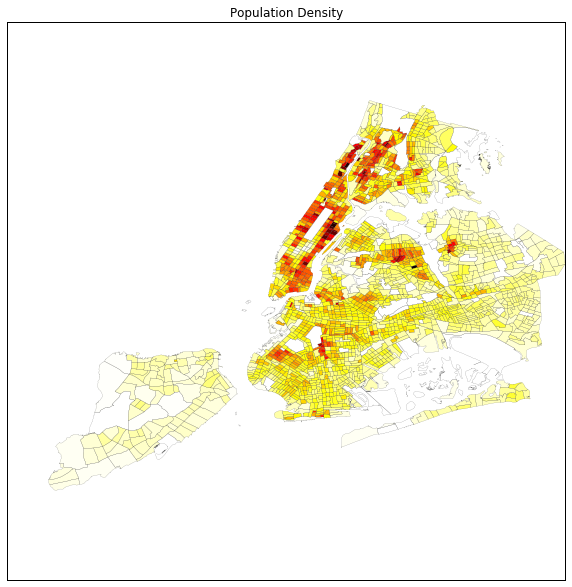

In [89]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Explore CitiBike data

### Load CitiBike data
### Extract the seasonal data

In [90]:
os.getenv("PUIDATA") 

In [91]:
#monthly data by station
#how are the seasons defined
#winter Dec 21st - March 20th
#summer June 20th - September 22nd - according to almanac.com
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head(300)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0


## extract the winter and summer data

In [92]:

# summer extraction for months June, July, August and September
df_summer = df_bike_monthly[(df_bike_monthly.index.month >= 6 ) & (df_bike_monthly.index.month <= 9 )]
df_summer.head(30)


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,2422,...,0,0,0,0,0,0,0,0,0,0
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,0
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,0
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,0,0
2015-06-30,2309,0,9457,3426,5859,4763,1809,5190,2695,2116,...,0,0,0,0,0,0,0,0,0,0
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,0


In [93]:
df_winter = df_bike_monthly[(df_bike_monthly.index.month <= 3 ) | (df_bike_monthly.index.month == 12 )]
df_winter.head(30)


,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,1009,...,0,0,0,0,0,0,0,0,0,0
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,0
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,0
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,0
2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,878,...,0,0,0,0,0,0,0,0,0,0
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,0,0,0
2015-02-28,562,0,2130,913,1363,1140,356,1023,891,447,...,0,0,0,0,0,0,0,0,0,0
2015-03-31,1012,0,3574,1401,2201,2047,617,1867,1505,769,...,0,0,0,0,0,0,0,0,0,0
2015-12-31,1873,2502,7101,2678,3968,3492,1420,3620,3251,1654,...,0,0,0,0,0,0,0,0,0,0


## time series analysis


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

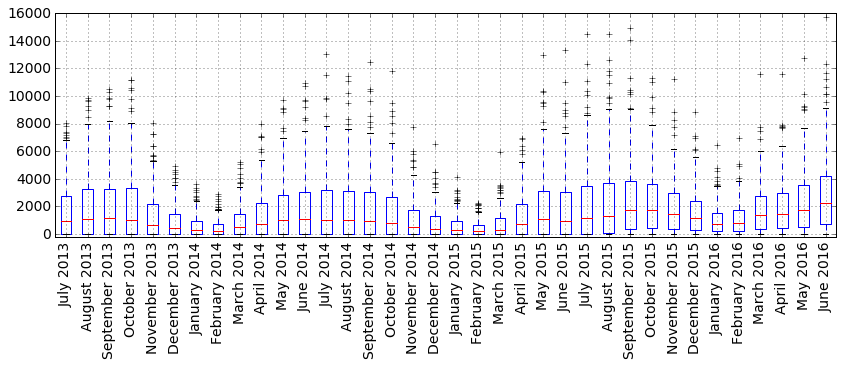

In [94]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

#### Seasonal Decomposition

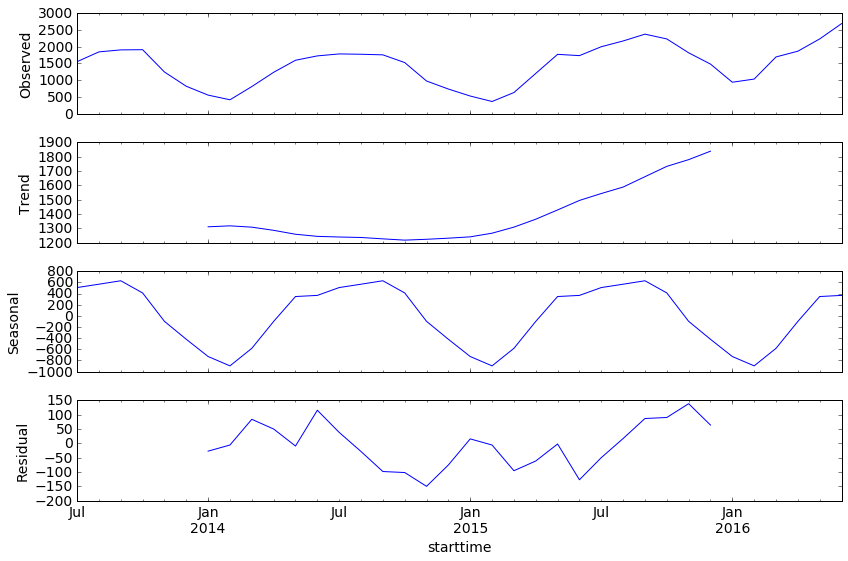

In [95]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

## REwork the plots above for the seasons


## Map CitiBike Data to CT level

### Load CitiBike station location data

In [96]:
#get the station ID's work in a table, have a bunch of lat and long  - zip the lat long together ith shapely, need to pply
#shapley geometry.points, to translate zip to points, and compare them, 
#tell pandas keep it as a string because need to have an indicies as a string, because the columns are a string, have to keep it a s a string
#always have them as a string
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [97]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [99]:

a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    #print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

In [100]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [101]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
## created two new columns for seasonal averages winter and summer
station_id['MonthlyAve']=df_bike_monthly.sum()
station_id['WinterAve']=df_winter.sum()
station_id['SummerAve']=df_summer.sum()

In [102]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve,WinterAve,SummerAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,13163,30696
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,16113,45966
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,52940,118837
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,19541,44794
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,31319,82749


### Add the monthly average rides to the CT shapefile 

In [103]:
# winter average
temp=station_id[['WinterAve']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_WinterAve=ct_shape.join(temp)
ct_shape_WinterAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [104]:
# summer average
temp2=station_id[['SummerAve']]
temp2['station_id']=station_id.index
temp2.index=station_id['BoroCT2010']
ct_shape_SummerAve=ct_shape.join(temp2)
ct_shape_SummerAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


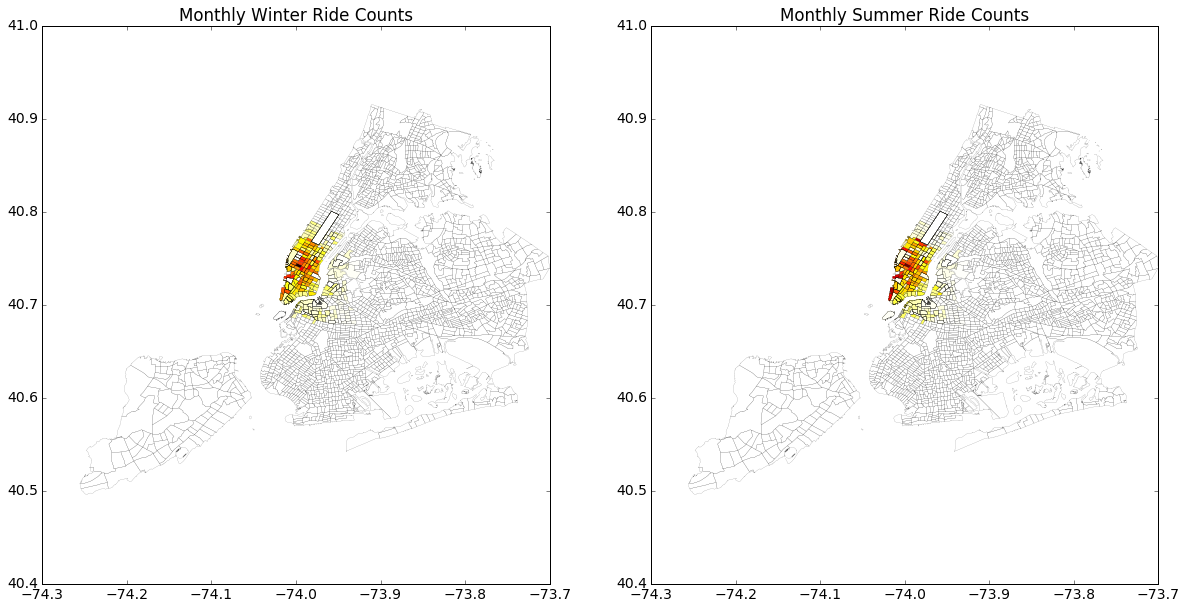

In [105]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ct_shape_WinterAve.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Monthly Winter Ride Counts")
ax2 = plt.subplot(122)
ct_shape_SummerAve.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Monthly Summer Ride Counts")


Figures above are too small so I am going to zoom in 

### Removing the CTs that are out of zoom boundries

In [106]:
ct_shape_WinterAve_Zoom=(ct_shape_WinterAve[ct_shape_WinterAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

ct_shape_SummerAve_Zoom=(ct_shape_SummerAve[ct_shape_SummerAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [117]:
print( 'Total number of CTs',len(ct_shape))
print ('Number of zoomed winter CTs:', len(temp.WinterAve))
print ('Number of zoomed summer CTs:', len(temp2.SummerAve))
print

Total number of CTs 2166
Number of zoomed winter CTs: 543
Number of zoomed summer CTs: 543


<function print>

### Map the monthly rides 

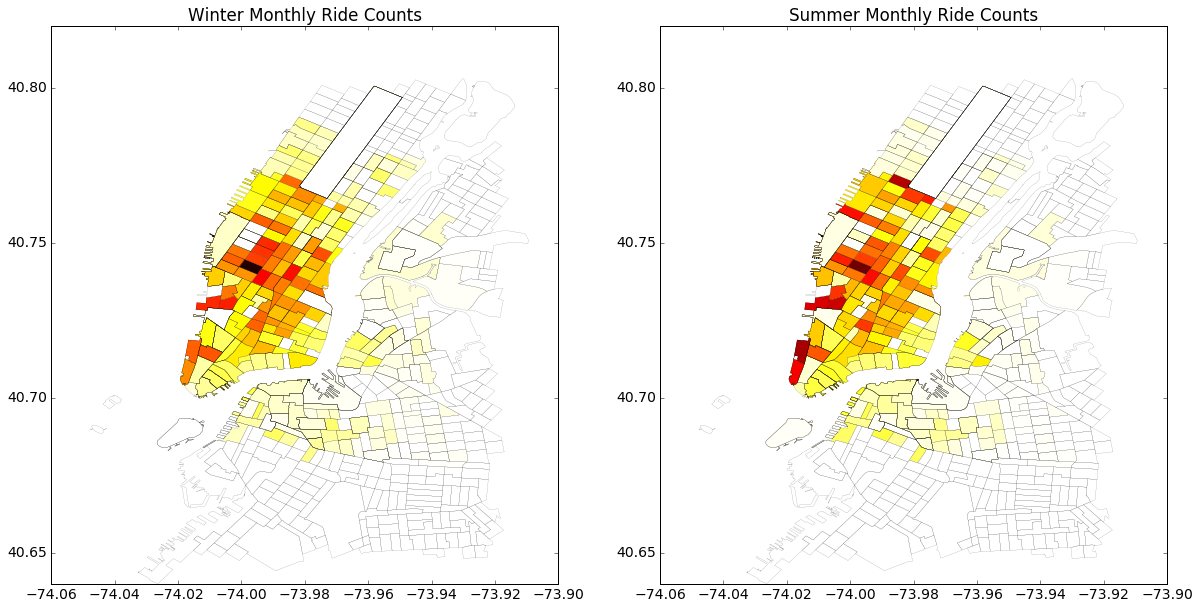

In [118]:
f, ax = plt.subplots(figsize=(20,10))
ax1 = plt.subplot(121)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_WinterAve_Zoom.plot(column='WinterAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
plt.title("Winter Monthly Ride Counts")

ax2 = plt.subplot(122)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_SummerAve_Zoom.plot(column='SummerAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Summer Monthly Ride Counts")

Figures HW10_dlk253 A and B: This shows a heatmap for the density of citibike users during the Winter months on the left and the Summer months on right. At first glance the maps look pretty similar, but there is more ride counts in the summer months in areas in downton as well as the upper west side/west side. The 

### Export Shapefile CTs in the CitiBike Zone

Just want to do the analysis on the zoom part. Get the file and use pysal

In [119]:
path='Output/ct_shape_WinterAve_Zoom.shp'
ct_shape_WinterAve_Zoom.to_file(path)
path='Output/ct_shape_SummerAve_Zoom.shp'
ct_shape_SummerAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

In [120]:
import pysal as ps

### Spatial Weights
Contiguity: Queen Weights

In [121]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [122]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [123]:
#queen weight of census track of shape file
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [124]:
Wmatrix, ids = qW_CT.full()

In [125]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [126]:
#row standardized
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
#filtering of the neighbors, can't be a neighbor of myself
connected friend sof neighbors, it would report the friends of the pixels, weighted average, 
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [127]:
Winter_MonthlyRide=ct_shape_WinterAve_Zoom.WinterAve
Winter_MonthlyRideLag=ps.lag_spatial(qW_CT, Winter_MonthlyRide)

Summer_MonthlyRide=ct_shape_SummerAve_Zoom.SummerAve
Summer_MonthlyRideLag=ps.lag_spatial(qW_CT, Summer_MonthlyRide)

#### Create Quantiles for maping

In [128]:
Winter_MonthlyRideLagQ10 = ps.Quantiles(Winter_MonthlyRideLag, k=10)
Winter_MonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    55.143                 2
   55.143 < x[i] <=   902.271                78
  902.271 < x[i] <=  2165.333                80
 2165.333 < x[i] <=  3452.913                79
 3452.913 < x[i] <=  5014.083                80
 5014.083 < x[i] <= 11249.113                79
11249.113 < x[i] <= 15205.882                80
15205.882 < x[i] <= 18477.420                79
18477.420 < x[i] <= 29902.786                80

In [129]:
Summer_MonthlyRideLagQ10 = ps.Quantiles(Summer_MonthlyRideLag, k=10)
Summer_MonthlyRideLagQ10

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    88.000                 2
   88.000 < x[i] <=  1511.625                78
 1511.625 < x[i] <=  3075.000                80
 3075.000 < x[i] <=  7551.400                81
 7551.400 < x[i] <= 11627.857                78
11627.857 < x[i] <= 25693.803                79
25693.803 < x[i] <= 37395.214                80
37395.214 < x[i] <= 43198.655                79
43198.655 < x[i] <= 66036.500                80

#### Map the monthly rides lag

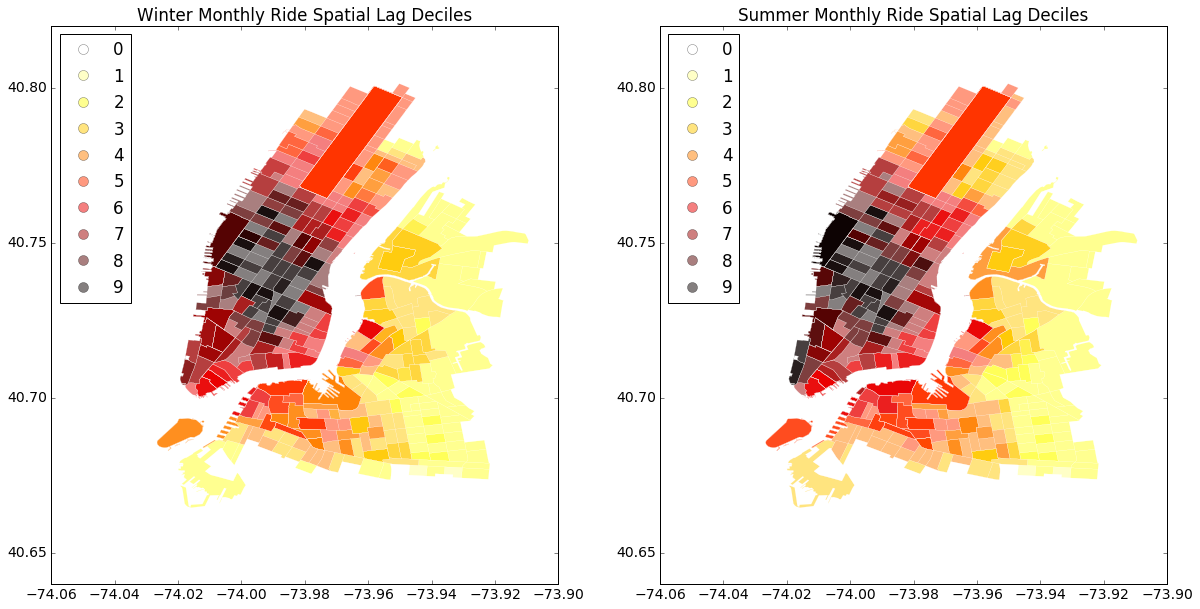

In [130]:
f, ax = plt.subplots(figsize=(20, 10))
ax1 = plt.subplot(121)
ct_shape_WinterAve_Zoom.assign(cl=Winter_MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_SummerAve_Zoom.assign(cl=Summer_MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=False)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles")


Figures HW10_dlk253 C and D show deciles of monthly citibike usage during the winter months on the left and the summer months on the right. In the summer it looks like the tracks are lower, but it is hard to tell from this small map. It might be better to zoom in and do this analysis by neighborhood. 

## Global  Spatial Autocorrelation

In [131]:
b,a = np.polyfit(Winter_MonthlyRide, Winter_MonthlyRideLag, 1)
b,a 

b2,a2 = np.polyfit(Summer_MonthlyRide, Summer_MonthlyRideLag, 1)
b2,a2 

(0.6438931431258913, 5682.9310787418508)

### Moran Scatterplot

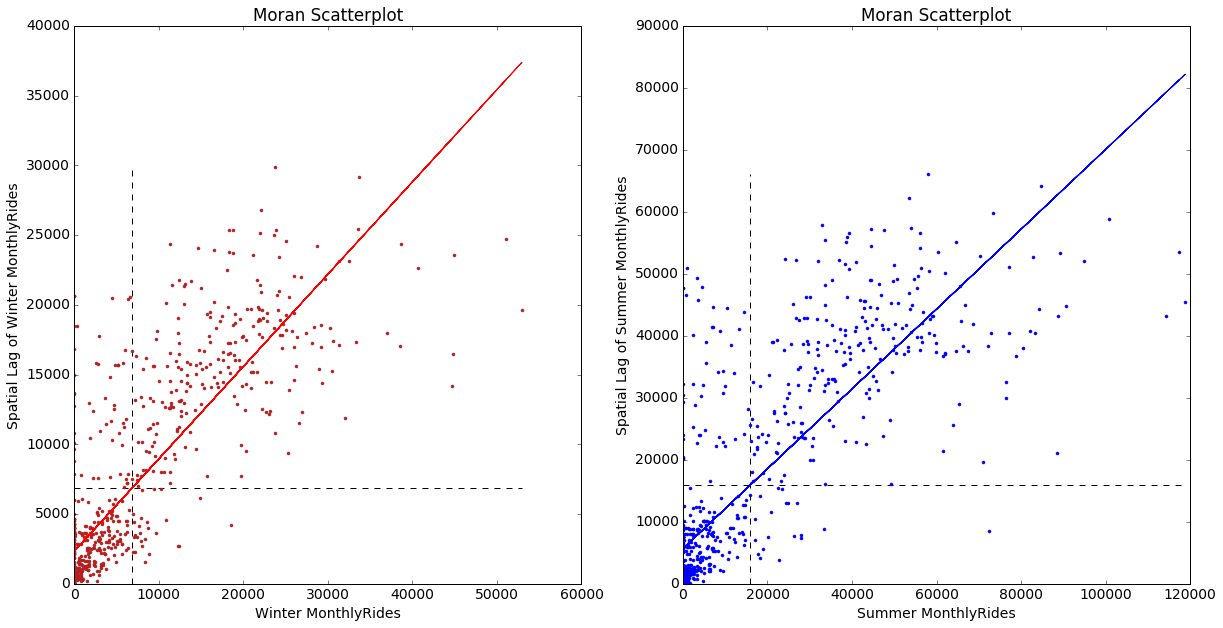

In [133]:
f, ax = plt.subplots(1, figsize=(20, 10))
ax1 = plt.subplot(121)
plt.plot(Winter_MonthlyRide, Winter_MonthlyRideLag, '.', color='firebrick')
 # dashed vert at mean of the last year's PCI
plt.vlines(Winter_MonthlyRide.mean(), Winter_MonthlyRideLag.min(), Winter_MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Winter_MonthlyRideLag.mean(), Winter_MonthlyRide.min(), Winter_MonthlyRide.max(), linestyle='--')
# red line of best fit using global I as slope
plt.plot(Winter_MonthlyRide, a + b*Winter_MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')

ax2 = plt.subplot(122)
plt.plot(Summer_MonthlyRide, Summer_MonthlyRideLag, '.', color='blue')
 # dashed vert at mean of the last year's PCI
plt.vlines(Summer_MonthlyRide.mean(), Summer_MonthlyRideLag.min(), Summer_MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Summer_MonthlyRideLag.mean(), Summer_MonthlyRide.min(), Summer_MonthlyRide.max(), linestyle='--')
# red line of best fit using global I as slope
plt.plot(Summer_MonthlyRide, a2 + b2*Summer_MonthlyRide, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('Summer MonthlyRides')




Figure HW10_dlk253 E and F. This is a Moran scatterplot for Winter Monthly Rides on the Left and Summer Monthly Rides on the Right. 

### Moran's I

In [134]:
I_Winter_MonthlyRide = ps.Moran(Winter_MonthlyRide, qW_CT)
I_Summer_MonthlyRide = ps.Moran(Summer_MonthlyRide, qW_CT)

In [135]:
I_Winter_MonthlyRide.I, I_Winter_MonthlyRide.p_sim


(0.66204419671059411, 0.001)

In [136]:
I_Summer_MonthlyRide.I, I_Summer_MonthlyRide.p_sim

(0.6440694990680973, 0.001)

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [137]:
I_Winter_MonthlyRide.sim[0:10]

array([ 0.00587841,  0.00495349, -0.02768635, -0.00944167, -0.00355218,
        0.01372163,  0.02232808,  0.01651995,  0.0309668 , -0.01914154])

In [138]:
I_Summer_MonthlyRide.sim[0:10]

array([-0.01807276,  0.00199555,  0.02792027,  0.03789405,  0.00614626,
       -0.00433508, -0.00252304, -0.01687912, -0.0025667 , -0.00436953])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [139]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

(-0.7, 0.7)

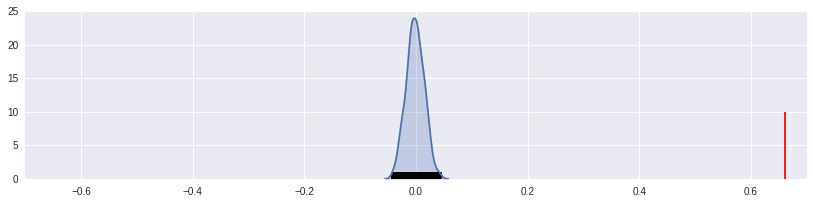

In [140]:
sns.kdeplot(I_Winter_MonthlyRide.sim, shade=True)
plt.vlines(I_Winter_MonthlyRide.sim, 0, 1)
plt.vlines(I_Winter_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

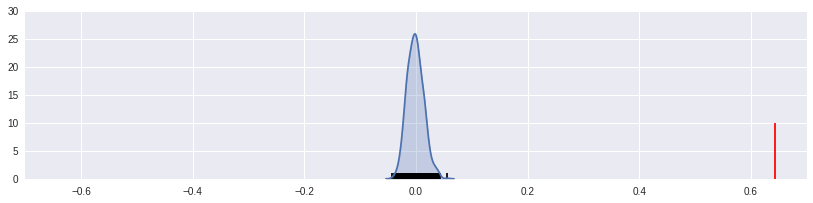

In [141]:
sns.kdeplot(I_Summer_MonthlyRide.sim, shade=True)
plt.vlines(I_Summer_MonthlyRide.sim, 0, 1)
plt.vlines(I_Summer_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

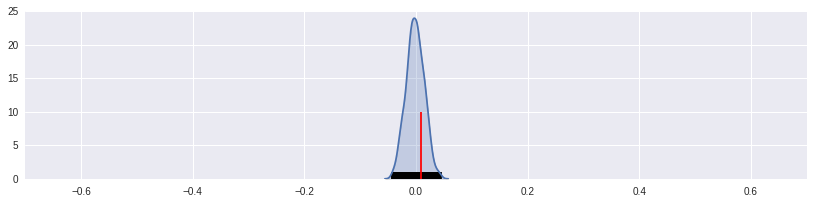

In [142]:
sns.kdeplot(I_Winter_MonthlyRide.sim, shade=True)
plt.vlines(I_Winter_MonthlyRide.sim, 0, 1)
plt.vlines(I_Winter_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

(-0.7, 0.7)

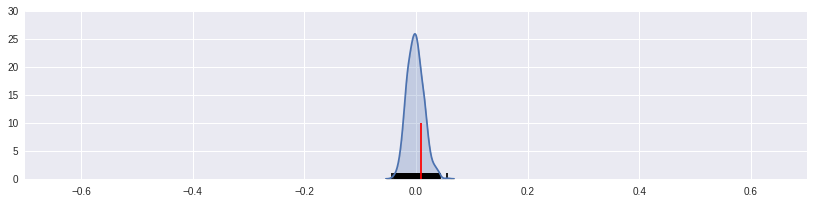

In [143]:
sns.kdeplot(I_Summer_MonthlyRide.sim, shade=True)
plt.vlines(I_Summer_MonthlyRide.sim, 0, 1)
plt.vlines(I_Summer_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [144]:
LMo_Winter_MonthlyRide = ps.Moran_Local(Winter_MonthlyRide, qW_CT,permutations=999)

In [145]:
LMo_Winter_MonthlyRide.Is[0:5], LMo_Winter_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.3153042 , -0.00110645, -0.00100209, -0.06082761]),
 array([ 0.001,  0.13 ,  0.467,  0.485,  0.443]))

In [146]:
LMo_Summer_MonthlyRide = ps.Moran_Local(Summer_MonthlyRide, qW_CT,permutations=999)

In [147]:
LMo_Summer_MonthlyRide.Is[0:5], LMo_Summer_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.23689404,  0.01179723,  0.00235718,  0.0247348 ]),
 array([ 0.001,  0.189,  0.335,  0.358,  0.37 ]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [150]:
Wsigs = Winter_MonthlyRide[LMo_Winter_MonthlyRide.p_sim <= .001]
W_sigs = Winter_MonthlyRideLag[LMo_Winter_MonthlyRide.p_sim <= .001]
Winsigs = Winter_MonthlyRide[LMo_Winter_MonthlyRide.p_sim > .001]
W_insigs = Winter_MonthlyRideLag[LMo_Winter_MonthlyRide.p_sim > .001]

Ssigs = Summer_MonthlyRide[LMo_Summer_MonthlyRide.p_sim <= .001]
S_sigs = Summer_MonthlyRideLag[LMo_Summer_MonthlyRide.p_sim <= .001]
Sinsigs = Summer_MonthlyRide[LMo_Summer_MonthlyRide.p_sim > .001]
S_insigs = Summer_MonthlyRideLag[LMo_Summer_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

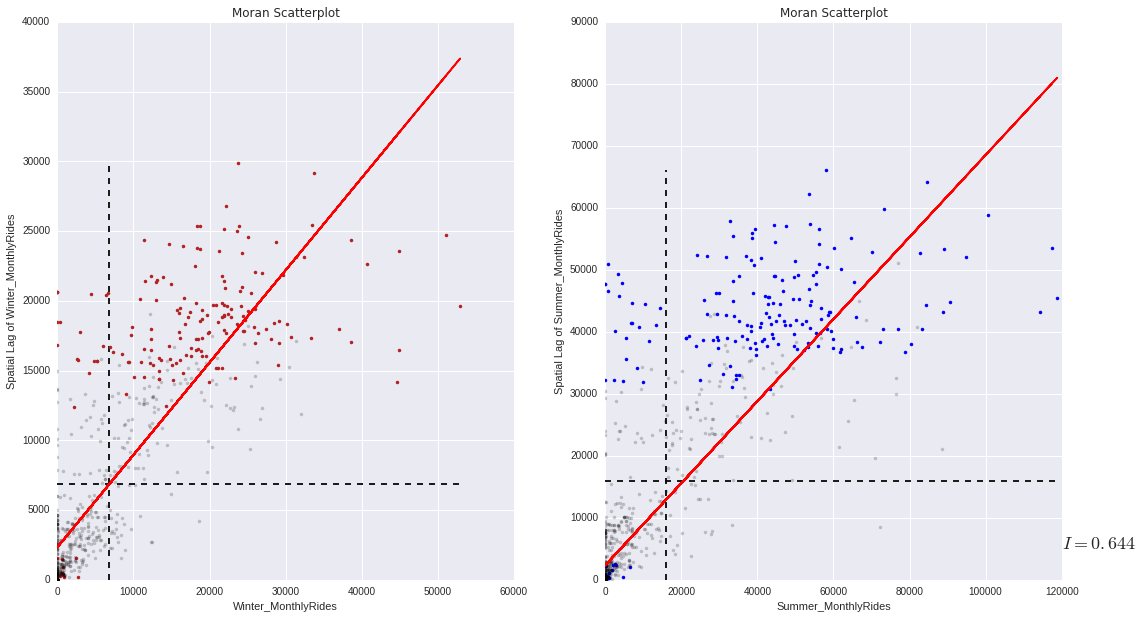

In [153]:
f, ax = plt.subplots(figsize=(18, 10))

ax1 = plt.subplot(121)
plt.plot(Wsigs, W_sigs, '.', color='firebrick')
plt.plot(Winsigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_Winter_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(Winter_MonthlyRide.mean(), Winter_MonthlyRideLag.min(), Winter_MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Winter_MonthlyRideLag.mean(), Winter_MonthlyRide.min(), Winter_MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(Winter_MonthlyRide, a + b*Winter_MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter_MonthlyRides')
plt.xlabel('Winter_MonthlyRides')



ax2 = plt.subplot(122)
plt.plot(Ssigs, S_sigs, '.', color='blue')
plt.plot(Sinsigs, S_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_Summer_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(Summer_MonthlyRide.mean(), Summer_MonthlyRideLag.min(), Summer_MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Summer_MonthlyRideLag.mean(), Summer_MonthlyRide.min(), Summer_MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(Summer_MonthlyRide, a + b*Summer_MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer_MonthlyRides')
plt.xlabel('Summer_MonthlyRides')


Fig G and H. This shows a Moran scatterplot for monthly (winter left and summer right) citibike usage 

### Hot and Cold spots 

In [164]:
Wsig = LMo_Winter_MonthlyRide.p_sim < 0.01
Whotspots = LMo_Winter_MonthlyRide.q==1 * Wsig
Wcoldspots = LMo_Winter_MonthlyRide.q==3 * Wsig
print ("Number of Hotspots Winter:", Whotspots.sum())
print ("Number of Coldspots Winter:", Wcoldspots.sum())
Ssig = LMo_Summer_MonthlyRide.p_sim < 0.01
Shotspots = LMo_Summer_MonthlyRide.q==1 * Ssig
Scoldspots = LMo_Summer_MonthlyRide.q==3 * Ssig
print ("Number of Hotspots (Summer):", Shotspots.sum())
print ("Number of Coldspots (Summer):", Scoldspots.sum())

Number of Hotspots Winter: 195
Number of Coldspots Winter: 212
Number of Hotspots (Summer): 191
Number of Coldspots (Summer): 239


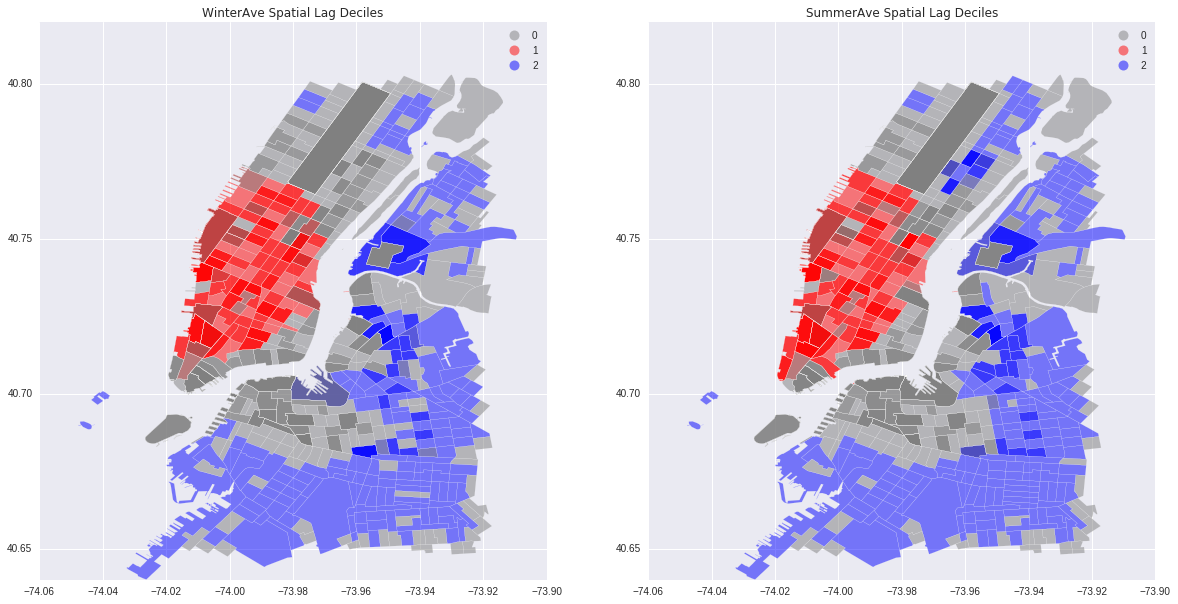

In [165]:
from matplotlib import colors

Whcmap = colors.ListedColormap(['grey','red','blue'])
Whotcold = Whotspots*1 + Wcoldspots*2
Shcmap = colors.ListedColormap(['grey','red','blue'])
Shotcold = Shotspots*1 + Scoldspots*2

f, ax = plt.subplots(figsize=(20, 10))
ax1 = plt.subplot(121)
ct_shape_WinterAve_Zoom.assign(cl=Whotcold).plot(column='cl', categorical=True, 
        k=10, cmap=Whcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WinterAve Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_SummerAve_Zoom.assign(cl=Shotcold).plot(column='cl', categorical=True, 
        k=10, cmap=Shcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SummerAve Spatial Lag Deciles")

Figure X:  According to these plots, if the cell is red it means that you ride frequently and your neighbors ride frequently. If the cells are blue, it means that you ride infrequently and your neighbors ride infrequently. When it is gray, it means that you ride frequently but your neighbords don't ride frequently. At first glance for summer and winter this seems pretty similar. Looking closer one can see that there is more gray in brooklyn, queens for summer. 

Some Questions: I wonder how this realtes to time and the workday. As most people work and commute with citybike in manhattan, this information is telling. Also citibike is not is some of the neighborhoods in blue, so this may be problematic. 